# Adversarial Attacks and Training

### HW5 @ DL Course, Dr. Soleymani

*Full Name:* Mehdi Jamalkhah


In this notebook, we will explore adversarial attacks and training methods in deep learning. First, we will train a simple model, ResNet18, on the CIFAR-10 dataset. Next, we will learn about two different adversarial attacks: FGSM (Fast Gradient Sign Method) and PGD (Projected Gradient Descent). To enhance our understanding, we will implement the PGD attack from scratch, while the FGSM attack will be implemented using a library. After this, we will use the FGSM attack to generate adversarial examples and then perform adversarial training on the model using the CIFAR-10 dataset. Finally, we will compare the performance and robustness of the adversarially trained model with the original model. 

## outline
- Train Resnet on CIFAR10
- FGSM Attack using torchattacks
- PGD Attack from scratch
- Visualization
- Adversarial Training


In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.autograd import Variable
from tqdm import tqdm
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import torchattacks

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


## Train Resnet on CIFAR10

In [3]:
batch_size = 32
transform = transforms.Compose([transforms.ToTensor(),])

trainset = torchvision.datasets.CIFAR10(root='../data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='../data', train=False, download=True, transform=transform)
trainset, valset = random_split(trainset, [45000, 5000])

trainloader =  DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
valloader = DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [4]:
class resnet(nn.Module):
  def __init__(self, num_cls):
    super().__init__()
    self.conv = nn.Sequential(*list(resnet18(weights=None).children())[:-2])
    self.fc = nn.Linear(512, num_cls)

  def forward(self, x):
    x = self.conv(x)
    x = torch.flatten(x, start_dim=1)
    logits = self.fc(x)
    return logits


model = resnet(len(classes)).to(device)

In [5]:
learning_rate = 0.0001
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
epochs = 40

In [6]:
def correct(output, target):
    _, predicted = output.max(1)
    return predicted.eq(target).sum().item()

def eval(model, evalloader):
    with torch.no_grad():
        corrects = 0
        size = 0
        for batch, labels in evalloader:
            batch, labels = batch.to(device), labels.to(device)

            output = model(batch)

            corrects += correct(output, labels)
            size += len(labels)
            
    return corrects / size


In [ ]:
for epoch in range(epochs):
    total_loss = 0.0
    corrects = 0
    for batch, labels in trainloader:
        batch, labels = batch.to(device), labels.to(device)

        output = model(batch)
        loss = criterion(output, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss
        corrects += correct(output, labels)
        
        del output
        torch.cuda.empty_cache()
    print(f"Epoch [{epoch+1}/{epochs}]; Loss: {total_loss / len(trainloader):.4}; Train Acc: {corrects/len(trainset):.2}; Eval Acc: {eval(model, valloader): .2}")


Epoch [1/40]; Loss: 1.846; Train Acc: 0.33; Eval Acc:  0.42
Epoch [2/40]; Loss: 1.502; Train Acc: 0.46; Eval Acc:  0.47
Epoch [3/40]; Loss: 1.365; Train Acc: 0.51; Eval Acc:  0.5
Epoch [4/40]; Loss: 1.268; Train Acc: 0.55; Eval Acc:  0.52
Epoch [5/40]; Loss: 1.179; Train Acc: 0.58; Eval Acc:  0.54
Epoch [6/40]; Loss: 1.098; Train Acc: 0.61; Eval Acc:  0.54
Epoch [7/40]; Loss: 1.027; Train Acc: 0.64; Eval Acc:  0.56
Epoch [8/40]; Loss: 0.9541; Train Acc: 0.66; Eval Acc:  0.56
Epoch [9/40]; Loss: 0.8859; Train Acc: 0.69; Eval Acc:  0.57
Epoch [10/40]; Loss: 0.8225; Train Acc: 0.71; Eval Acc:  0.57
Epoch [11/40]; Loss: 0.7642; Train Acc: 0.74; Eval Acc:  0.58
Epoch [12/40]; Loss: 0.6947; Train Acc: 0.76; Eval Acc:  0.58
Epoch [13/40]; Loss: 0.6331; Train Acc: 0.78; Eval Acc:  0.58
Epoch [14/40]; Loss: 0.5781; Train Acc: 0.8; Eval Acc:  0.58
Epoch [15/40]; Loss: 0.52; Train Acc: 0.82; Eval Acc:  0.58
Epoch [16/40]; Loss: 0.4729; Train Acc: 0.84; Eval Acc:  0.59
Epoch [17/40]; Loss: 0.4239;

In [22]:
print(f"Test Acc: {eval(model, testloader): .3}")

Test Acc:  0.595


In [23]:
# Save model
model.eval()
model_name = "resnet18_cifar10_model_pretrained.pth"
model_PATH = f"../vars/adversarial/{model_name}"
torch.save(model.state_dict(), model_PATH)

## FGSM Attack using torchattacks

In this section we will run FGSM attack using [torchattacks library](https://adversarial-attacks-pytorch.readthedocs.io/en/latest/index.html).

We run the attack for $\epsilon \in \{\frac{1}{255}, \frac{4}{255}, \frac{8}{255}\}$ and report the performance of the model on untargeted FGSM attack on the test data.

In [7]:
def attack_and_eval(attack, testloader):
    corrects, size = 0, 0
    for batch, labels in testloader:
        batch, labels = batch.to(device), labels.to(device)

        adv_images = attack(batch, labels)

        output = model(adv_images)
        corrects += correct(output, labels)
        size += len(labels)
    
    return corrects/ size

In [ ]:
# Untargeted FGSM attack for epsilon = 1/255 

attack = torchattacks.FGSM(model, eps=1/255)

acc = attack_and_eval(attack, testloader)
print(f"Test acc after FGSM attack (epsilon = 1/255):{acc: .3f}")

Test acc after FGSM attack (epsilon = 1/255): 0.259


In [38]:
# Untargeted FGSM attack for epsilon = 4/255
attack = torchattacks.FGSM(model, eps=4/255) 

acc = attack_and_eval(attack, testloader)
print(f"Test acc after FGSM attack (epsilon = 4/255):{acc: .3f}")

Test acc after FGSM attack (epsilon = 4/255): 0.026


In [40]:
# Untargeted FGSM attack for epsilon = 8/255
attack = torchattacks.FGSM(model, eps=8/255) 

acc = attack_and_eval(attack, testloader)
print(f"Test acc after FGSM attack (epsilon = 8/255):{acc: .3f}")

Test acc after FGSM attack (epsilon = 8/255): 0.008


## PGD Attack from scratch

In this section we will implement PGD attack from scratch.

In [8]:
class LinfPGDAttack(object):

    def __init__(self, model, epsilon=8/255, k=2, alpha=2/255):
        self.model = model
        self.epsilon = epsilon
        self.steps = k
        self.alpha = alpha

    
    def __call__(self, images, labels):

        images = images.to(device)
        labels = labels.to(device)

        out = self.model(images)
        _, pred = torch.max(out, 1)

        perturbed_images = images.clone().requires_grad_()
        perturbed_images.to(device)
        
        for _ in range(self.steps):
            output = self.model(perturbed_images)
            criterion = nn.CrossEntropyLoss()
            loss = criterion(output, labels)
            grad = torch.autograd.grad(loss, perturbed_images)[0]
            
            perturbed_images = perturbed_images + torch.clamp(self.alpha * torch.sign(grad), min=-self.epsilon, max=self.epsilon)

        return  torch.where((pred == labels).view(-1, 1, 1, 1), perturbed_images, images)

In [135]:
# Evaluate PGD attack on the trained model with k=2,4,8

k_list = [2,4,8]

linfPGDAttack_list = [LinfPGDAttack(model, k=k) for k in k_list]
accs = [attack_and_eval(linfPGDAttack, testloader) for linfPGDAttack in linfPGDAttack_list]

print(f"Test acc after PGD attack: \n (k = 2):{accs[0]: .4f} \n (k = 4):{accs[1]: .4f} \n (k = 8):{accs[2]: .4f}")

Test acc after PGD attack: 
 (k = 2): 0.0118 
 (k = 4): 0.0001 
 (k = 8): 0.0000


## Visualization

In [285]:
import matplotlib.pyplot as plt

def show_image(img):
    img = img.permute(1, 2, 0)
    plt.imshow(img.cpu().detach().numpy())
    plt.axis("off")
    

def attack_and_plot(attack, images, labels):
    images, labels = images.to(device), labels.to(device)
    B = len(images)
    
    adv_images = attack(images, labels)
    out = model(adv_images)
    _, adv_labels = torch.max(out, 1)
    
    plt.subplots_adjust(hspace=0.5)
    for i, image, adv_image, label, adv_label in zip(range(B*2), images, adv_images, labels, adv_labels):
        
        plt.subplot(B, 2, 2*i+1)
        show_image(image)
        plt.title("Real: " + classes[label.item()])
        plt.subplot(B, 2, 2*i+2)
        show_image(adv_image)
        plt.title("Adv: " + classes[adv_label.item()])

### FGSM Attack (eps = 8/255)

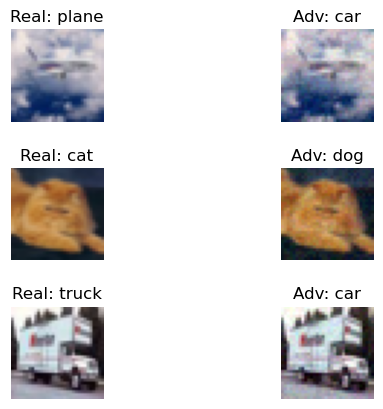

In [286]:
random_indices = torch.randperm(len(testset))[:3]
images = torch.stack([testset[idx][0] for idx in random_indices])
labels = torch.tensor([testset[idx][1] for idx in random_indices])

attack = torchattacks.FGSM(model, eps=8/255)
attack_and_plot(attack, images, labels)

### PGD Attack (k = 8)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


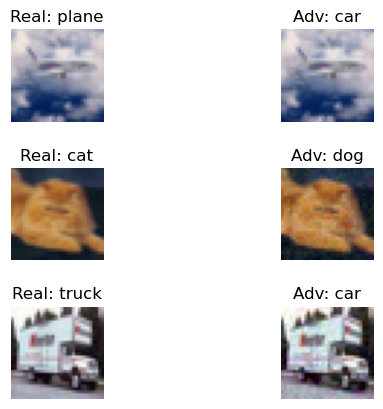

In [291]:
attack_and_plot(linfPGDAttack_list[2], images, labels)

## Adversarial Training

In this section we are going to adversarially train our model and see the results. 

In [10]:
adv_model = resnet(len(classes))
adv_model.to(device)

learning_rate = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(adv_model.parameters(), lr=learning_rate, momentum=0.9)
epochs = 60
for epoch in range(epochs):
    corrects = 0
    for batch, labels in trainloader:
        batch, labels = batch.to(device), labels.to(device)
         
        attack = torchattacks.FGSM(adv_model, eps=8/255) 
        adv_batch = attack(batch, labels)
        
        output = adv_model(adv_batch)
        
        loss = criterion(output, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        corrects += correct(output, labels)
        
    print(f"Epoch [{epoch+1}/{epochs}]: Train Acc: {corrects/len(trainset): .3f}; Val Acc: {eval(adv_model, valloader): .3f}")

Epoch [1/60]: Train Acc:  0.209; Val Acc:  0.372
Epoch [2/60]: Train Acc:  0.257; Val Acc:  0.406
Epoch [3/60]: Train Acc:  0.284; Val Acc:  0.447
Epoch [4/60]: Train Acc:  0.299; Val Acc:  0.456
Epoch [5/60]: Train Acc:  0.319; Val Acc:  0.484
Epoch [6/60]: Train Acc:  0.330; Val Acc:  0.512
Epoch [7/60]: Train Acc:  0.341; Val Acc:  0.526
Epoch [8/60]: Train Acc:  0.352; Val Acc:  0.533
Epoch [9/60]: Train Acc:  0.363; Val Acc:  0.541
Epoch [10/60]: Train Acc:  0.374; Val Acc:  0.522
Epoch [11/60]: Train Acc:  0.386; Val Acc:  0.554
Epoch [12/60]: Train Acc:  0.396; Val Acc:  0.575
Epoch [13/60]: Train Acc:  0.405; Val Acc:  0.550
Epoch [14/60]: Train Acc:  0.415; Val Acc:  0.572
Epoch [15/60]: Train Acc:  0.425; Val Acc:  0.575
Epoch [16/60]: Train Acc:  0.434; Val Acc:  0.565
Epoch [17/60]: Train Acc:  0.444; Val Acc:  0.593
Epoch [18/60]: Train Acc:  0.457; Val Acc:  0.595
Epoch [19/60]: Train Acc:  0.463; Val Acc:  0.583
Epoch [20/60]: Train Acc:  0.480; Val Acc:  0.597
Epoch [21

In [11]:
print(f"Test Acc of Adv_model: {eval(adv_model, testloader): .3f}")

Test Acc of Adv_model:  0.631


In [12]:
# FGSM attack on the adversarially trained model with epsilon = 8/255

fgsm_attack = torchattacks.FGSM(adv_model, eps=8/255) 

acc = attack_and_eval(fgsm_attack, testloader)
print(f"Test acc after FGSM attack (epsilon = 8/255):{acc: .3f}")

Test acc after FGSM attack (epsilon = 8/255): 0.111


In [13]:
# PGD attack on the adversarially trained model with k=4

pgd_attack = LinfPGDAttack(model, k=4) 
acc = attack_and_eval(pgd_attack, testloader)
print(f"Test acc after PGD attack (k = 4):{acc: .3f}")

Test acc after PGD attack (k = 4): 0.009


**Questions:**

- **What happened to the accuracy of the adversarially trained model?**

    The training accuracy decreased, but the validation accuracy improved, indicating that the model became more generalized. This outcome was expected because altering the training data helps the model learn meaningful features rather than overfitting to irrelevant patterns.

- **What do you conclude from the result of the FGSM attack on the adversarially trained model?**

    The model became more robust against the FGSM attack, though its resilience is still limited.

- **What do you conclude from the result of the PGD attack on the adversarially trained model?**

    Although the model showed some robustness, it remained vulnerable, as its accuracy dropped significantly under the PGD attack.

- **What is your final conclusion?**

    In this example, adversarial training improves the model’s generalization and robustness against specific attacks. Typically, adversarial training tends to reduce generalization. However, in this case, the model was overfitted initially, which is why adversarial training had a positive effect.

